136
136
Extracting parameters from C:\Users\jerem\Downloads\segments\100_Skateboard_NP_CCW_Corrected_Standard.set...
Not setting metadata
174 matching events found
No baseline correction applied
0 projection items activated
Ready.


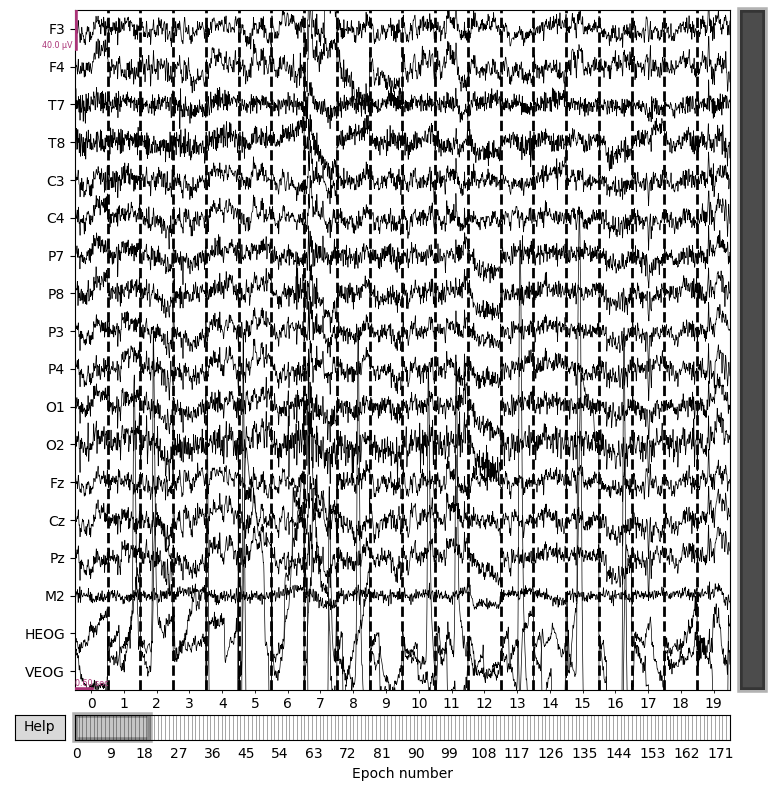

Extracting parameters from C:\Users\jerem\Downloads\segments\100_Skateboard_NP_CW_Corrected_Standard.set...
Not setting metadata
181 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from C:\Users\jerem\Downloads\segments\100_Skateboard_P_CCW_Corrected_Standard.set...
Not setting metadata
163 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from C:\Users\jerem\Downloads\segments\100_Skateboard_P_CW_Corrected_Standard.set...
Not setting metadata
183 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from C:\Users\jerem\Downloads\segments\101_Skateboard_NP_CCW_Corrected_Standard.set...
Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from C:\Users\jerem\Downloads\segments\101_Skateboard_NP_CW_Corrected_Standard.set...
Not s

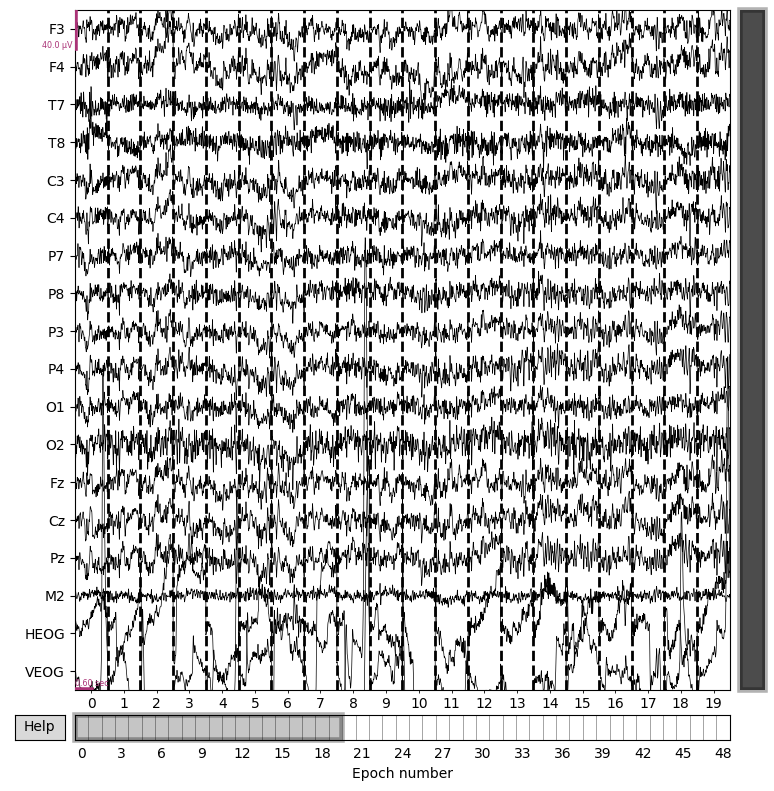

Extracting parameters from C:\Users\jerem\Downloads\segments\100_Skateboard_NP_CCW_Corrected_Target.set...
Not setting metadata
49 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from C:\Users\jerem\Downloads\segments\100_Skateboard_NP_CW_Corrected_Target.set...
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from C:\Users\jerem\Downloads\segments\100_Skateboard_P_CCW_Corrected_Target.set...
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from C:\Users\jerem\Downloads\segments\100_Skateboard_P_CW_Corrected_Target.set...
Not setting metadata
44 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from C:\Users\jerem\Downloads\segments\101_Skateboard_NP_CCW_Corrected_Target.set...
Not setting metad

In [26]:
import matplotlib.pyplot as plt # plotting library
import mne
import numpy as np 
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import glob

x = []
standard = glob.glob(r'C:\Users\jerem\Downloads\segments\*standard.set')#get the name of all standard .set files
print(len(standard))
target = glob.glob(r'C:\Users\jerem\Downloads\segments\*target.set')#get the name of all target .set files
print(len(target))

for i in range(136):
    #data_path = r"C:\Users\jerem\Downloads\Winter2019\%s.vhdr"
    epochs1 = mne.io.read_epochs_eeglab(standard[i])
    if i == 0:        
        epochs1.plot(block=True) 
        plt.show()
for j in range(136):
    if j == 0:
        epochs2 = mne.io.read_epochs_eeglab(target[j])
        epochs2.plot(block=True) 
        plt.show()
    if j == 113:
        epochs2 = mne.io.read_raw_eeglab(target[j])
    elif j!= 113:
        epochs2 = mne.io.read_epochs_eeglab(target[j])
        
train_loader_std = torch.utils.data.DataLoader(standard, batch_size=136)
train_loader_target = torch.utils.data.DataLoader(target, batch_size=136)
    
test_loader_std = torch.utils.data.DataLoader(standard, batch_size=1,shuffle=True)
test_loader_target = torch.utils.data.DataLoader(target, batch_size=1,shuffle=True)

In [27]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential( #three convolutional layers, use 1d since we don't need the color info
            nn.Conv1d(18, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv1d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(True),
            nn.Conv1d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential( #two fully connected layers
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

In [28]:
class Decoder(nn.Module): #decoder has the same architecture with the encoder but in inverse order
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose1d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm1d(16),
            nn.ReLU(True),
            nn.ConvTranspose1d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU(True),
            nn.ConvTranspose1d(18, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [29]:
input_test = torch.rand(1, 18, 1199000)

# model = nn.Conv1d(18, 8, 3, stride=2, padding=1)
# model(input_test)

model = nn.Sequential( #three convolutional layers 
            nn.Conv1d(18, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv1d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(True),
            nn.Conv1d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

model(input_test)
# self.encoder_cnn = nn.Sequential( #three convolutional layers 
#     nn.Conv2d(18, 8, 3, stride=2, padding=1),
#     nn.ReLU(True),
#     nn.Conv2d(18, 16, 3, stride=2, padding=1),
#     nn.BatchNorm2d(16),
#     nn.ReLU(True),
#     nn.Conv2d(16, 32, 3, stride=2, padding=0),
#     nn.ReLU(True)
# )


tensor([[[0.0721, 0.3082, 0.6758,  ..., 0.0594, 0.3934, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0417],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.2966, 0.0000, 0.0000],
         [0.3642, 0.0000, 0.0147,  ..., 0.0000, 0.0000, 0.5746],
         [0.0000, 0.0000, 0.2809,  ..., 0.0000, 0.0000, 0.4395]]],
       grad_fn=<ReluBackward0>)

In [30]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)



Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose1d(32, 16, kernel_size=(3,), stride=(2,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose1d(16, 8, kernel_size=(3,), stride=(2,), padding=(1,), output_padding=(1,))
    (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose1d(18, 1, kernel_size=(3,), stride=(2,), padding=(1,), output_padding=(1,))
  )
)

In [41]:
### Training function
def train_epoch(encoder, decoder, device, train_loader_std, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    #sklearn.model_selection.train_test_split(*arrays, test_size=1, train_size=136, random_state=None, shuffle=True, stratify=None)
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for data, _ in train_loader_std: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        for epoch in range(136):#training standard
            for i in tqdm(range(len(data))): #show the process of training
        # Move tensor to the proper device
                #data = data.to(device)
        # Encode data
                encoded_data = encoder(data)
        # Decode data
                decoded_data = decoder(data)
        # Evaluate loss
                loss = loss_fn(decoded_data, data)
        # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        # Print batch loss
            print('\t EPOCH {}/{}'.format(epoch + 1, num_epochs))
            print('\t partial train loss (single batch): %f' % (loss.data))
            train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

In [33]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            for epoch in range(256):
                for i in tqdm(range(len(image_batch))):
            # Move tensor to the proper device
                    image_batch = image_batch.to(device)
            # Encode data
                    encoded_data = encoder(image_batch)
            # Decode data
                    decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
                    conc_out.append(decoded_data.cpu())
                    conc_label.append(image_batch.cpu())
            print('\t EPOCH {}/{}'.format(epoch + 1, num_epochs))
        # Create a single tensor with all the values in the lists
            conc_out = torch.cat(conc_out)
            conc_label = torch.cat(conc_label) 
        # Evaluate global loss
            val_loss = loss_fn(conc_out, conc_label)
            print('\t val_loss{}'.format(val_loss))
    return val_loss.data

In [34]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

In [35]:
num_epochs = 30
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    train_loss =train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
    val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)
    plot_ae_outputs(encoder,decoder,n=10)

NameError: name 'train_loader' is not defined

In [ ]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

In [ ]:
#plot how the reconstruction losses decrease over the epochs
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [ ]:
# Generate new samples from the random latent code
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = iter(test_loader).next()
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()

In [ ]:
#observe dynamic visualization to see the latent space learned by the autoencoder:

#create the encoded samples using the test set
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

In [ ]:
#plot the latent space representation using plotly express library
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)

In [ ]:
# visualize the latent code in a 2d space
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()